# Тематическая модель [Постнауки](http://postnauka.ru)
## Peer Review (optional)

В этом задании мы применим аппарат тематического моделирования к коллекции текстовых записей видеолекций, скачанных с сайта Постнаука. Мы будем визуализировать модель и создавать прототип тематического навигатора по коллекции. В коллекции 1728 документов, размер словаря - 38467 слов. Слова лемматизированы, то есть приведены к начальной форме, с помощью программы [mystem](https://tech.yandex.ru/mystem/), коллекция сохранена в [формате vowpal wabbit](http://docs.bigartm.org/en/latest/formats.html). В каждой строке до первой черты записана информация о документе (ссылка на страницу с лекцией), после первой черты следует описание документа. Используются две модальности - текстовая ("text") и модальность авторов ("author"); у каждого документа один автор.

Для выполнения задания понадобится библиотека [BigARTM](http://docs.bigartm.org). В демонстрации показан пример использования библиотеки версии 0.7.4, на сайте предлагается скачивать версию 0.8.0. В новой версии изменены принципы работы со словарями: они вынесены в отдельный класс (пример в [Release Notes](http://docs.bigartm.org/en/stable/release_notes/python.html)). Строить модель и извлекать ее параметры нужно так же, как показано в демонстрации. Вы можете использовать [предыдущий релиз](http://bigartm.readthedocs.io/en/v0.7.6/download.html) или [новый релиз](http://docs.bigartm.org/en/latest/download.html) на ваше усмотрение.

Спецификации всех функций вы можете смотреть на странице [Python API](http://bigartm.readthedocs.io/en/stable/python_interface.html).

In [1]:
import artm

In [2]:
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline
seaborn.set_style("whitegrid", {'axes.grid' : False})

/Users/ko.bykov/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
import numpy as np
import pandas as pd

/Users/ko.bykov/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


##### Считывание данных

Создайте объект класса artm.BatchVectorizer, который будет ссылаться на директорию с пакетами данных (батчами). Чтобы библиотека могла преобразовать текстовый файл в батчи, создайте пустую директорию и укажите ее название в параметре target_folder. Размер батча для небольших коллекций (как наша) не важен, вы можете указать любой.

In [4]:
# Ваш код
#batch_vectorizer = artm.BatchVectorizer(data_path="lectures.txt", data_format="vowpal_wabbit", target_folder="lectures_batches", batch_size=100)

batch_vectorizer = artm.BatchVectorizer(data_path="lectures_batches", data_format='batches')

##### Инициализация модели

Создайте объект класса artm.Model с 30 темами, именами тем, указанными ниже и единичными весами обеих модальностей. Количество тем выбрано не очень большим, чтобы вам было удобнее работать с темами. На этой коллекции можно строить и большее число тем, тогда они будут более узко специализированы.

In [5]:
T = 30   # количество тем
topic_names=["sbj"+str(i) for i in range(T-1)]+["bcg"]
# Ваш код

model_artm = artm.ARTM(num_topics=T, topic_names=topic_names, class_ids={"text":1, "author":2}, 
                       num_document_passes=1, reuse_theta=True, cache_theta=True, seed=-1)

Мы будем строить 29 предметных тем и одну фоновую. 

Соберите словарь с помощью метода gather_dictionary и инициализируйте модель, указав random_seed=1. Обязательно укажите свое название словаря, оно понадобится при добавлении регуляризаторов.

In [6]:
# Ваш код
#  gather_dictionary выпилен https://bigartm.readthedocs.io/en/stable/release_notes/python.html
np.random.seed(1) # у метода gather нет параметра random_seed, делаем как раньше
dictionary = artm.Dictionary('dictionary')

dictionary.gather(batch_vectorizer.data_path)

##### Добавление score

Создайте два измерителя качества artm.TopTokensScore - по одному для каждой модальности; количество токенов 15. Названия для score придумайте самостоятельно.

In [7]:
# Ваш код
model_artm.scores.add(artm.TopTokensScore(name="top_words", num_tokens=15, class_id="text"))
model_artm.scores.add(artm.TopTokensScore(name="top_authors", num_tokens=15, class_id="author"))

##### Построение модели

Мы будем строить модель в два этапа: сначала добавим сглаживающий регуляризатор фоновой темы и настроим параметры модели, затем - добавим разреживающий регуляризатор предметрых тем и выполним еще несколько итераций. Так мы сможем получить наиболее чистые от фоновых слов предметные темы. Сглаживающий и разреживающий регуляризаторы задаются одним и тем же классом artm.SmoothSparsePhiRegularizer: если коэффициент tau положительный, то регуляризатор будет сглаживающий, если отрицательный - разреживающий.

Если вы хотите подробнее разобраться, как выполняется регуляризация тематической модели в BigARTM, вы можете прочитать [статью](https://s3-eu-west-1.amazonaws.com/artm/voron-potap14artm-rus.pdf), раздел 4.

Добавьте сглаживающий регуляризатор с коэффициентом tau = 1e5, указав название своего словаря в dictionary, модальность текста в class_ids и тему "bcg" в topic_names.

In [8]:
# Ваш код
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', \
                                                            tau=1e5, dictionary=dictionary, \
                                                            class_ids=["text"],
                                                            topic_names="bcg"))

Выполните 30 итераций по коллекции (num_collection_passes), количество внутренних итераций установите равным 1. Используйте метод fit_offline модели.

In [9]:
# Ваш код
# без понятия, что за "внутренние итерации"
model_artm.initialize('dictionary')
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)

Добавьте разреживающий регуляризатор с коэффициентом tau=-1e5, указав название своего словаря, модальность текста в class_ids и все темы "sbjX" в topic_names.

In [10]:
# Ваш код
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi2', \
                                                            tau=-1e5, dictionary=dictionary, \
                                                            class_ids=["text"],
                                                            topic_names="sbjX"))

/Users/ko.bykov/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Выполните еще 15 проходов по коллекции.

In [11]:
# Ваш код
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

##### Интерпретация тем

Используя созданные score, выведите топы слов и топы авторов в темах. Удобнее всего выводить топ слов каждой темы с новой строки, указывая название темы в начале строки, и аналогично с авторами.

In [15]:
#print(model_artm.score_tracker["top_words"].tokens)
print(model_artm.score_tracker["top_authors"].last_tokens)

{'sbj0': ['Александр_Марей', 'Фёдор_Успенский', 'Павел_Уваров', 'Татьяна_Бобровникова', 'Алексей_Юдин', 'Игорь_Данилевский', 'Ольга_Вайнштейн', 'Елена_Уханова', 'Ольга_Брилева', 'Владимир_Петрухин', 'Григорий_Бондаренко', 'Елена_Браун', 'Ольга_Тогоева', 'Екатерина_Болтунова', 'Раиса_Кирсанова'], 'sbj1': ['Сергей_Попов', 'Кирилл_Еськов', 'Александр_Марков', 'Дмитрий_Титов', 'Андрей_Иванцов', 'Валерий_Сулейманов', 'Зоригто_Намсараев', 'Дмитрий_Вибе', 'Елизавета_Ривкина', 'Наталья_Новикова', 'Роман_Рафиков', 'Александр_Слободкин', 'Андрей_Глазовский', 'Юлия_Краус', 'Армен_Мулкиджанян'], 'sbj2': ['Елена_Брызгалина', 'Эмиль_Ахмедов', 'Владимир_Мележик', 'Михаил_Пантелеев', 'Владимир_Шалаев', 'Александр_Поддьяков', 'Алексей_Желтиков', 'Антон_Суворов', 'Василий_Климов', 'Даниэль_Сельва', 'Михаил_Фейгельман', 'Юджин_Ползик', 'Алексей_Акимов', 'Виталий_Пальчиков', 'Илья_Щуров'], 'sbj3': ['Виталий_Куренной', 'Михаил_Соколов', 'Александр_Доброхотов', 'Максим_Кронгауз', 'Владимир_Миронов', 'Никола

In [18]:
# Ваш код

for topic_name in model_artm.topic_names:
    print (topic_name, end=": words ")
    tokens = model_artm.score_tracker["top_words"].last_tokens
    for word in tokens[topic_name]:    
        print (word, end=" ")
    print()
    print (topic_name, end=": authors ")
    tokens = model_artm.score_tracker["top_authors"].last_tokens
    for author in tokens[topic_name]:    
        print (author, end=" ")
    print()
    print()


sbj0: words быть что это этот который как свой они век власть человек тот мочь его весь 
sbj0: authors Александр_Марей Фёдор_Успенский Павел_Уваров Татьяна_Бобровникова Алексей_Юдин Игорь_Данилевский Ольга_Вайнштейн Елена_Уханова Ольга_Брилева Владимир_Петрухин Григорий_Бондаренко Елена_Браун Ольга_Тогоева Екатерина_Болтунова Раиса_Кирсанова 

sbj1: words быть что планета это звезда который этот земля мочь очень как они такой система атмосфера 
sbj1: authors Сергей_Попов Кирилл_Еськов Александр_Марков Дмитрий_Титов Андрей_Иванцов Валерий_Сулейманов Зоригто_Намсараев Дмитрий_Вибе Елизавета_Ривкина Наталья_Новикова Роман_Рафиков Александр_Слободкин Андрей_Глазовский Юлия_Краус Армен_Мулкиджанян 

sbj2: words система этот который быть что это как такой для они один или другой если время 
sbj2: authors Елена_Брызгалина Эмиль_Ахмедов Владимир_Мележик Михаил_Пантелеев Владимир_Шалаев Александр_Поддьяков Алексей_Желтиков Антон_Суворов Василий_Климов Даниэль_Сельва Михаил_Фейгельман Юджин_Полз

sbj25: authors Владимир_Плунгян Кирилл_Бабаев Игорь_Исаев Илья_Иткин Георгий_Старостин Григорий_Крейдлин Владимир_Беликов Екатерина_Лямина Евгений_Зуев Алексей_Шмелев Андрей_Кофман Андрей_Кибрик Дмитрий_Баюк Яков_Тестелец Дмитрий_Дагаев 

sbj26: words быть что этот который это как человек экономический год мочь они для решение тот такой 
sbj26: authors Фуад_Алескеров Олег_Хлевнюк Алексей_Белянин Ольга_Малинова Владимир_Гимпельсон Сергей_Соколовский Ольга_Гулевич Сергей_Бобылев Сергей_Афонцев Виктор_Полтерович Сергей_Пекарский Сергей_Гуриев Леонард_Полищук Василий_Ключарев Рауль_Гайнетдинов 

sbj27: words клетка быть что это который этот днк они белок как ген мочь такой для организм 
sbj27: authors Константин_Северинов Максим_Франк-Каменецкий Евгений_Шеваль Михаил_Гельфанд Сергей_Киселев Антон_Буздин Петр_Федичев Сергей_Румянцев Светлана_Боринская Светлана_Баньковская Сергей_Саложин Сергей_Науменко Евгений_Куликов Георгий_Базыкин Инга_Полетаева 

sbj28: words быть это этот что который у

В последней теме "bcg" должны находиться общеупотребительные слова.

Важный шаг в работе с тематической моделью, когда речь идет о визуализации или создании тематического навигатора, это именование тем. Понять, о чем каждая тема, можно по списку ее топовых слов. Например, тему
    
    частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый
    
можно назвать "Физика элементарных частиц". 

Дайте названия 29 предметным темам. Если вы не знаете, как назвать тему, назовите ее первым встретившимся в ней существительным, хотя при таком подходе навигатор будет менее информативным. Из названий тем составьте список из 29 строк и запишите го в переменную sbj_topic_labels. В переменной topic_labels будут храниться названия всех тем, включая фоновую.

In [54]:
sbj_topic_labels = [\
    "власть", "астрономия", "система aliexpress", "культура и наука", "право",
    "свойства материалов", "кино", "генеалогия", "химия", "квантовая физика",
    "октябрьская революция", "воспитание детей", "биология", "культурология", "физика черных дыр",
    "информатика", "антропология", "политология", "лингвистика", "общество aliexpress",   
     "урбанистика", "медицина", "социология", "обществознание", "теология"
     "языкознание", "экономика", "микробиология", "электрофизика"
                    
]   # запишите названия тем в список
topic_labels = sbj_topic_labels + ["Фоновая тема"]

/Users/ko.bykov/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


##### Анализ тем

Далее мы будем работать с распределениями тем в документах (матрица $\Theta$) и авторов в темах (одна из двух матриц $\Phi$, соответствующая модальности авторов). 
Создайте переменные, содержащие две этих матрицы, с помощью методов get_phi и get_theta модели. Назовите переменные theta и phi_a. Выведите формы обеих матриц, чтобы понять, по каким осям стоят темы.

In [55]:
model_artm.theta_columns_naming = "title" # включает именование столбцов Theta их названиями-ссылками, а не внутренними id 
# Ваш код - интересно, в чем смысл такого задания
theta = model_artm.get_theta()
phi_a = model_artm.get_phi(class_ids=["author"])

Визуализируем фрагмент матрицы $\Theta$ - первые 100 документов (это наиболее простой способ визуально оценить, как темы распределяются в документах). С помощью метода seaborn.heatmap выведите фрагмент theta как изображение. Рекомендация: создайте фигуру pyplot размера (20, 10).

<AxesSubplot:>

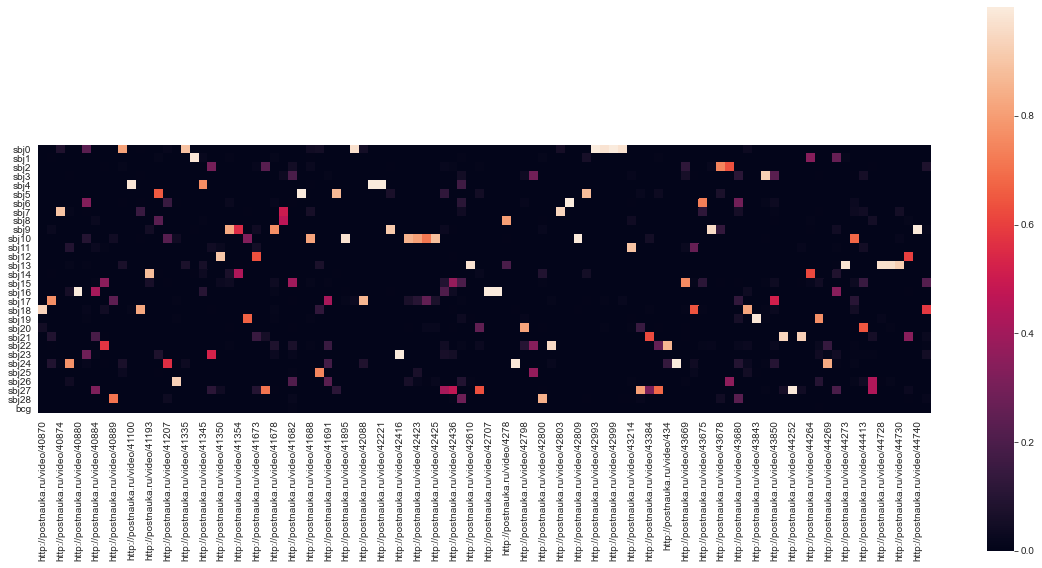

In [56]:
# Ваш код
theta_head = theta.iloc[: , :100]
plt.figure(figsize=(20, 10))
seaborn.heatmap(theta_head, square=True)

Вы должны увидеть, что фоновая тема имеет большую вероятность в почти каждом документе, и это логично. Кроме того, есть еще одна тема, которая чаще других встречается в документах. Судя по всему, это тема содержит много слов по науку в целом, а каждый документ (видео) в нашей коллекции связан с наукой. Можно (необязательно) дать этой теме название "Наука".

Помимо этих двух тем, фоновой и общенаучной, каждый документ характеризуется малым числом других тем.

Оценим $p(t)$ - долю каждой темы во всей коллекции. По формуле полной вероятности вычислять эти величины нужно как
$p(t) = \sum_d p(t|d) p(d)$. Согласно вероятностной модели, $p(d)$ пропорционально длине документа d. Поступим проще: будем полагать, что все документы равновероятны. Тогда оценить $p(t)$ можно, просуммировав $p(t|d)$ по всем документам, а затем разделив полученный вектор на его сумму. 

Создайте переменную-датафрейм с T строками, индексированными названиями тем, и 1 столбцом, содержащим оценки $p(t)$. Выведите датафрейм на печать.

In [59]:
# Ваш код
docs_count = theta.shape[1]
subj_probs = []
for i in range(0, len(sbj_topic_labels)):
    subj_probs.append(theta.iloc[i, :].mean())

subj_df = pd.DataFrame(data=subj_probs, index=sbj_topic_labels, columns=["prob"]).sort_values(by=['prob'], ascending=False)

print(subj_df)

                           prob
культура и наука       0.064444
электрофизика          0.064395
квантовая физика       0.051889
химия                  0.049216
физика черных дыр      0.045482
политология            0.043205
теологияязыкознание    0.042803
микробиология          0.041054
культурология          0.037486
информатика            0.036849
власть                 0.034626
биология               0.033489
социология             0.033485
урбанистика            0.033356
октябрьская революция  0.032829
астрономия             0.031798
свойства материалов    0.030790
обществознание         0.030067
лингвистика            0.028549
воспитание детей       0.026417
экономика              0.025712
система aliexpress     0.025521
медицина               0.025118
право                  0.022904
кино                   0.022220
общество aliexpress    0.021514
генеалогия             0.018381
антропология           0.018159


/Users/ko.bykov/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Найдите 5 самых распространенных и 3 наименее освещенных темы в коллекции (наибольшие и наименьшие $p(t)$ соответственно), не считая фоновую и общенаучную. Укажите названия, которые вы дали этим темам.

In [61]:
subj_df.head(5)

/Users/ko.bykov/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,prob
культура и наука,0.064444
электрофизика,0.064395
квантовая физика,0.051889
химия,0.049216
физика черных дыр,0.045482


In [62]:
subj_df.tail(3)

/Users/ko.bykov/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,prob
общество aliexpress,0.021514
генеалогия,0.018381
антропология,0.018159


Визуализируйте матрицу $\Phi$ модальности авторов в виде изображения. Рекомендация: установите yticklabels=False в heatmap.

<AxesSubplot:>

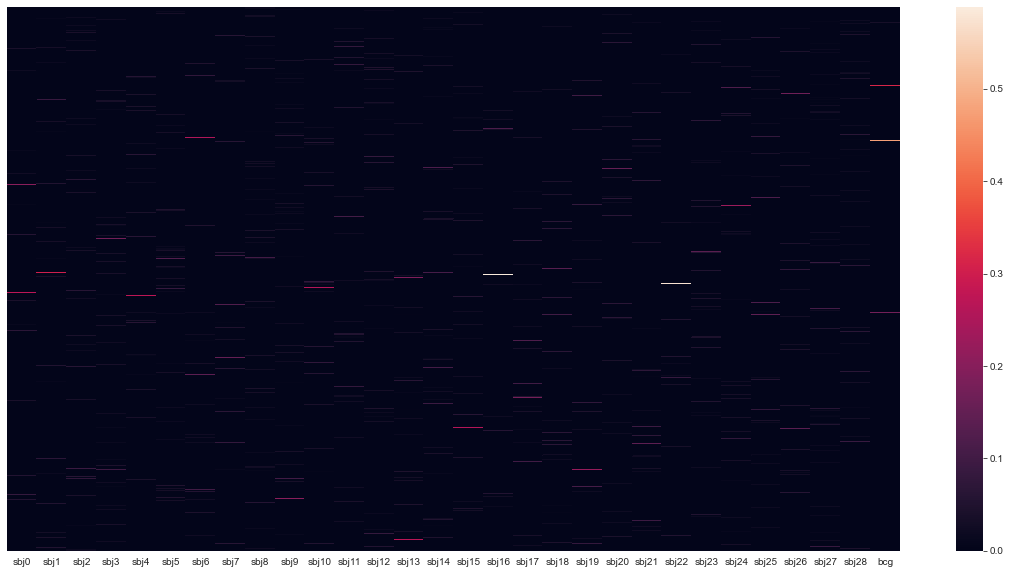

In [42]:
# Ваш код 
plt.figure(figsize=(20, 10))
seaborn.heatmap(phi_a, yticklabels=False)

Каждой теме соответствует не очень большое число авторов - матрица достаточно разреженная. Кроме того, некоторые темы имеют доминирующего автора $a$, имеющего большую вероятность $p(a|t)$ - этот автор записал больше всего лекций по теме. 

Будем считать, что автор $a$ значим в теме, если $p(a|t) > 0.01$. Для каждого автора посчитайте, в скольких темах он значим. Найдите авторов-рекордсменов, которые значимы (а значит, читали лекции) в >= 3 темах.

In [73]:
#print(phi_a)
names = []
for a in range(0, phi_a.shape[0]):
    count = 0
    for subj in range(0, phi_a.shape[1]):
        if phi_a.iloc[a, subj] > 0.01:
            count+=1
        if count >= 3:
            ind_name, name = phi_a.index[a]
            names.append(name)
            break
print(len(names))

15


In [70]:
print(names)

['Елена_Браун', 'Андрей_Летаров', 'Артем_Оганов', 'Александра_Архипова', 'Андрей_Журавлев', 'Сергей_Киселев', 'Павел_Нерлер_(Полян)', 'Андрей_Кибрик', 'Роман_Ефремов', 'Михаил_Алексеевский', 'Владимир_Муронец', 'Михаил_Маяцкий', 'Михаил_Соколов', 'Александр_Филиппов', 'Дмитрий_Бовыкин']


Большинство авторов значимы в 1 теме, что логично.

##### Построение тематической карты авторов

По сути, в матрице $\Phi$, соответствующей модальности авторов, записаны тематические кластеры авторов. Для любого автора мы можем составить его тематический круг - авторов, разбирающихся в той же теме, что и данный. Интересующиеся слушатели могут попробовать выполнить эту процедуру для ученых, читающих лекции на Постнауке, которых они знают (например, на Постнауке есть лекции с К. В. Воронцовым - лектором текущего модуля :)

Составим карту близости авторов по тематике их исследований. Для этого применим метод понижения размерности MDS к тематическим профилям авторов.

Чтобы получить тематический профиль автора, распределение $p(t|a)$, нужно воспользоваться формулой Байеса: 
$p(t|a) = \frac {p(a|t) p(t)} {\sum_t' p(a|t') p(t')}$. Все необходимые для этого величины у вас есть и записаны в переменных phi и pt. 

Передайте матрицу тематических профилей авторов, записанных по строкам, в метод MDS с n_components=2. Используйте косинусную метрику (она хорошо подходит для поиска расстояний между векторами, имеющими фиксированную сумму компонент).

In [ ]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

In [ ]:
# Ваш код


Визуализируйте найденные двумерные представления с помощью функции scatter. 

In [ ]:
# Ваш код


Должно получиться, что некоторые грппы авторов формируют сгустки, которые можно считать тематическими группами авторов.

Раскрасим точки следующим образом: для каждого автора выберем наиболее вероятную для него тему ($\max_t p(t|a)$), и каждой теме сопоставим цвет. Кроме того, добавим на карту имена и фамилии авторов, это можно сделать в цикле по всем точкам с помощью функции plt.annotate, указывая метку точки первым аргументом и ее координаты в аргументе xy. Рекомендуется сделать размер изображения большим, тогда маркеры точек тоже придется увеличить (s=100 в plt.scatter). Изобразите карту авторов и сохраните в pdf-файл с помощью функции plt.savefig. 

Метки авторов будут пересекаться. Будет очень хорошо, если вы найдете способ, как этого можно избежать.

In [ ]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, T)) # цвета для тем
# Ваш код


##### Создание простого тематического навигатора по Постнауке

Наш тематический навигатор будет для каждой темы показывать ее список слов, а также список релевантных теме документов. 

Нам понадобятся распределения $p(d|t)$. По формуле Байеса $p(d|t) = \frac{p(t|d)p(d)}{\sum_{d'}p(t|d')p(d')}$, но поскольку мы считаем документы равновероятными, достаточно разделить каждую строку $\Theta$ на ее сумму, чтобы оценить распределение. 

Отсортируйте матрицу $p(d|t)$ по убыванию $p(d|t)$ в каждой теме (то есть построчно). Нам понадобятся индексы наиболее вероятных документов в каждой теме, поэтому используйте функцию argmax.

In [ ]:
# Ваш код


Создавать навигатор мы будем прямо в jupiter notebook: это возможно благодаря тому факту, что при печати ссылки она автоматически превращается в гиперссылку.

In [ ]:
print "http://yandex.ru"   # получится кликабельная ссылка

Кроме того, подключив модуль [ipython.core.display](https://ipython.org/ipython-doc/2/api/generated/IPython.core.display.html), можно использовать html-разметку в выводе. Например:

In [ ]:
from IPython.core.display import display, HTML
display(HTML(u"<h1>Заголовок</h1>"))   # также <h2>, <h3>
display(HTML(u"<ul><li>Пункт 1</li><li>Пункт 2</li></ul>"))
display(HTML(u'<font color="green">Зеленый!</font>'))
display(HTML(u'<a href="http://yandex.ru">Еще один вариант вывода ссылки</a>'))

В цикле для каждой темы выведите ее заголовок, в следующей строке - топ-10 слов темы, затем в виде списка ссылки на 10 наиболее релевантных (по $p(d|t)$) теме документов. Используйте html-разметку. Творчество приветствуется :)

In [ ]:
# Ваш код


##### Заключение

В этом Peer Review мы познакомились с базовыми возможностями библиотеки BigARTM и с методами визуализации тематических моделей. Визуализация тематических моделей - это широкая и активно развивающаяся область научных исследований. Мы рассмотрели только самые простые приемы. Желающие могут попробовать применить [Serendip](http://vep.cs.wisc.edu/serendip/#serendipHero), разработанный в  University of Wisconsin-Madison, к построенной модели. Эта библиотека позволяет максимально полно охарактеризовать темы и написана для языка python. 

Сделав задание, вы можете выбрать в навигаторе наиболее интересную для вас тему и посмотреть видеолекции :) На Постнауке очень много интересных материалов. 